<a href="https://colab.research.google.com/github/pdrzxzz/pizza-or-not-pizza-image-classifier/blob/main/pizza_or_not_pizza_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle
# !pip install albumentations

In [69]:
# ============================== #
#         Import Libraries       #
# ============================== #

# Essential libraries for machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing from albumentations (Image augmentation)
import albumentations as A

# Image processing from skimage
from skimage import img_as_ubyte # Convert grayscale image to unsigned 8-bit format (required by LBP)
from skimage.io import imread  # To read image files
from skimage.transform import resize  # To resize images
from skimage.feature import local_binary_pattern  # To extract texture
from skimage import filters # sobel, prewitt... # To extract edges

# Scikit-learn Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Scikit-learn modules for training and evaluation
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


# Utilities
import kagglehub  # To download datasets directly from Kaggle using KaggleHub
import os  # For interacting with the operating system, such as file paths
import joblib # Save models

In [3]:
# ============================== #
#        Download Dataset        #
# ============================== #

# Download dataset from Kaggle using KaggleHub
path = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")

# Path to the folder containing the classes directories
data_path = os.path.join(path, os.listdir(path)[0])

# List all image classes (subdirectories) in the dataset folder, sorted for consistency
image_classes = sorted(os.listdir(data_path))[1:]

# Print dataset location and classes found for confirmation
print("Dataset directory:", data_path)
print("Classes found:", image_classes)

Dataset directory: /kaggle/input/pizza-not-pizza/pizza_not_pizza
Classes found: ['not_pizza', 'pizza']


In [4]:
# ========================================== #
#      Constants and Configurations          #
# ========================================== #

# Features to be extracted from images
FEATURES = ['gray', 'color', 'lbp', 'sobel']
# FEATURES = ['gray']

# Number of images to use from each class (can be limited for faster runs or place a huge value to use all the images)
NUM_IMAGES_PER_CLASS = 100000

# Size to which all images will be resized (width, height)
IMAGE_SIZE = (128, 128)

# Parameters for Local Binary Patterns (LBP)
LBP_RADIUS = 1                  # Radius of circle for LBP
LBP_N_POINTS = 8 * LBP_RADIUS  # Number of points to consider in LBP

# Random state for reproducibility in splitting and models
RANDOM_STATE = 0

# Define default augmentation pipeline
AUGMENTATION_PIPELINE = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    A.Rotate(limit=15, p=0.3),
])

In [5]:
# ========================================== #
#      Image Processing & Feature Utils      #
# ========================================== #

def load_and_resize_image(image_path, as_gray=True, augment=True):
    """
    Load an image from disk, resize it, optionally apply augmentation, and return the result.

    Parameters:
    - image_path (str): Path to the image file.
    - as_gray (bool): Load the image as grayscale if True; otherwise, as color.
    - augment (bool): Whether to apply Albumentations image augmentation.

    Returns:
    - np.ndarray: The resized (and possibly augmented) image.
    """
    image = imread(image_path, as_gray=as_gray)
    image = resize(image, IMAGE_SIZE, anti_aliasing=True)

    if augment:
        # Convert to uint8 format required by Albumentations
        image_uint8 = img_as_ubyte(image)

        if as_gray:
            # Albumentations expects grayscale images to have shape (H, W, 1)
            image_uint8 = image_uint8[..., np.newaxis]

        # Apply augmentation pipeline
        augmented = AUGMENTATION_PIPELINE(image=image_uint8)
        image_aug = augmented["image"]

        # Convert back to float32 normalized between 0 and 1
        image_aug = image_aug.astype(np.float32) / 255.0

        if as_gray:
            image_aug = image_aug[..., 0]  # Remove channel dimension

        return image_aug

    return image

def extract_color_histograms(image):
    """
    Extract 256-bin histogram features for each RGB channel and concatenate.

    Parameters:
    - image (np.ndarray): Color image array.

    Returns:
    - np.ndarray: Concatenated histogram vector (length 256 * 3 = 768).
    """

    # If image is grayscale, convert it to 3-channel by repeating it
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)

    # For each color channel (R,G,B), compute histogram counts
    histograms = [
        np.histogram(image[:, :, channel], bins=256, range=(0, 256))[0]
        for channel in range(3)
    ]
    # Concatenate histograms of all channels into one feature vector
    concatenated_hist = np.concatenate(histograms)
    return concatenated_hist

def extract_lbp_features(gray_image):
    """
    Compute Local Binary Pattern (LBP) histogram for a grayscale image.

    Parameters:
    - gray_image (np.ndarray): Grayscale image array.

    Returns:
    - np.ndarray: Normalized histogram of LBP patterns.
    """
    # Convert grayscale image to unsigned 8-bit format (required by LBP)
    image_uint8 = img_as_ubyte(gray_image)

    # Compute LBP using 'uniform' method
    lbp = local_binary_pattern(image_uint8, LBP_N_POINTS, LBP_RADIUS, method="uniform")

    # Define number of bins for histogram
    n_bins = LBP_N_POINTS + 2  # Number of possible LBP patterns in uniform method

    # Calculate normalized histogram of LBP
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return lbp_hist

In [6]:
# ========================================== #
#          Dataset Feature Extraction        #
# ========================================== #
def extract_features_from_image(img_path, features, augment=False):
    """
    Extract selected features from a single image and return concatenated vector.

    Parameters:
    - img_path (str): Path to the image file.
    - features (list of str): Feature types to extract.
    - augment (bool): Whether to apply augmentation.

    Returns:
    - np.ndarray: 1D vector of concatenated scaled features.
    """
    feature_arrays = {f: [] for f in features}

    # Load and resize gray image (augmentation handled inside)
    gray = load_and_resize_image(img_path, as_gray=True, augment=augment)

    if "gray" in features:
        feature_arrays["gray"].append(gray.flatten())

    if "color" in features:
        color_img = load_and_resize_image(img_path, as_gray=False, augment=augment)
        feature_arrays["color"].append(extract_color_histograms(color_img))

    if "lbp" in features:
        feature_arrays["lbp"].append(extract_lbp_features(gray))

    if "sobel" in features:
        sobel_img = filters.sobel(gray)
        feature_arrays["sobel"].append(sobel_img.flatten())

    if "prewitt" in features:
        prewitt_img = filters.prewitt(gray)
        feature_arrays["prewitt"].append(prewitt_img.flatten())

    arrays = []
    for f in features:
        array = np.array(feature_arrays[f])
        arrays.append(array)

    if len(arrays) > 1:
        X = np.concatenate(arrays, axis=1)
    else:
        X = arrays[0]
    return X



def process_dataset_from_paths(image_paths, labels, features=["gray"], augment=False):
    """
    Load dataset images, extract selected features and encode labels.

    Parameters:
    - features (list of str): Feature types to extract.
        Options include 'gray', 'color', 'lbp', 'sobel', 'prewitt'.

    Returns:
    - X (np.ndarray): Feature matrix of shape (num_samples, num_features).
    - y (np.ndarray): Encoded integer labels for each sample.
    """
    # Dictionary to hold lists of extracted features per feature type
    feature_arrays = {f: [] for f in features}
    processed_labels = []

    print(f"Total image paths received: {len(image_paths)}")
    print(f"images are going to be resize to", IMAGE_SIZE)

    for idx, img_path in enumerate(image_paths):
        label = os.path.basename(os.path.dirname(img_path))
        processed_labels.append(label)

        gray = load_and_resize_image(img_path, as_gray=True, augment=augment)

        if "gray" in features:
            feature_arrays["gray"].append(gray.flatten())

        if "color" in features:
            color_img = load_and_resize_image(img_path, as_gray=False, augment=augment)
            feature_arrays["color"].append(extract_color_histograms(color_img))

        if "lbp" in features:
            feature_arrays["lbp"].append(extract_lbp_features(gray))

        if "sobel" in features:
            sobel_img = filters.sobel(gray)
            feature_arrays["sobel"].append(sobel_img.flatten())

        if "prewitt" in features:
            prewitt_img = filters.prewitt(gray)
            feature_arrays["prewitt"].append(prewitt_img.flatten())

        print(f"\rProcessed {idx + 1}/{len(image_paths)}", end="", flush=True)

    print("\nFinished feature extraction.")

    arrays = []
    for f in features:
        array = np.array(feature_arrays[f])
        print(f" Feature '{f}' extracted shape: {array.shape}")
        arrays.append(array)

    if len(arrays) > 1:
        X = np.concatenate(arrays, axis=1)
    else:
        X = features[0]

    print(f"Final feature matrix shape: {X.shape}")

    return X, processed_labels

In [7]:
# ========================================== #
#      Model Evaluation and Visualization    #
# ========================================== #

def plot_learning_curve(model, X, y, title="Learning Curve", scoring="f1", cv_splits=5):
    """
    Plot the learning curve for a given model and dataset.

    Parameters:
    - model (estimator): A scikit-learn estimator (e.g., RandomForestClassifier).
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Target labels.
    - title (str): Title for the plot.
    - scoring (str): Metric to evaluate model performance (default = 'accuracy').
    - cv_splits (int): Number of cross-validation folds.
    """
    # Create a stratified K-fold split strategy
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    # Define relative sizes of training data to evaluate
    train_sizes = np.linspace(0.05, 0.95, 19)

    # Compute training and validation scores for different training sizes
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    # Compute mean and standard deviation for error bands
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

    # X-axis in percentage form for clarity
    percent_labels = [f"{int(p * 100)}%" for p in train_sizes]
    plt.xticks(train_sizes_abs, percent_labels, rotation=45)

    # Set plot titles and labels
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [80]:
# ========================================== #
#                  Training                  #
# ========================================== #

def train_grid_search(classifier, param_grid, X_train, X_test, y_train, y_test):
    """
    Perform hyperparameter tuning with GridSearchCV on Classifier.

    Parameters:
    - classifier: estimator object (e.g. RandomForestClassifier)
    - param_grid: dict, hyperparameters grid for GridSearchCV
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Labels.

    Returns:
    - best_model (estimator): Best estimator after grid search.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=3
    )
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test)
    print("Best hyperparameters found:", grid_search.best_params_)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy with best model: {test_accuracy:.4f}")
    test_f1 = f1_score(y_test, y_pred)
    print(f"Test F1-score with best model: {test_f1:.4f}")
    return grid_search.best_estimator_


In [93]:
# ========================================== #
#                Run Pipeline                #
# ========================================== #

# Step 1: List all image paths and labels
image_paths = []
labels = []

for image_class in image_classes:
    class_path = os.path.join(data_path, image_class)
    image_list = os.listdir(class_path)[:NUM_IMAGES_PER_CLASS]
    print(f"Class '{image_class}': found {len(image_list)} images")
    for image_file in image_list:
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(image_class)

print(f"Total images loaded: {len(image_paths)}")

# Step 2: Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label encoding mapping:")
for label, code in label_mapping.items():
    print(f" {label}: {code}")

# Step 3: Split into train/test before feature extraction
train_paths, test_paths, y_train, y_test = train_test_split(
    image_paths,
    labels,
    stratify=labels,
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE
)
print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

# Step 4: Extract features separately
print("\nExtracting features for training set...")
X_train, y_train = process_dataset_from_paths(train_paths, y_train, features=FEATURES, augment=True)
print(f"X_train shape: {X_train.shape}, y_train length: {len(y_train)}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("\nExtracting features for test set...")
X_test, y_test = process_dataset_from_paths(test_paths, y_test, features=FEATURES, augment=False)
print(f"X_test shape: {X_test.shape}, y_test length: {len(y_test)}")

X_test = scaler.transform(X_test)

# Step 2: Encode labels
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.transform(y_test)
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# PCA
print("\nFitting PCA on training features...")
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
print(f"PCA components chosen: {pca.n_components_}, explained variance retained: {pca.explained_variance_ratio_.sum():.2f}")
print(f"X_test_pca shape: {X_train_pca.shape}")

print("Transforming test features with PCA...")
X_test_pca  = pca.transform(X_test)
print(f"X_test_pca shape: {X_test_pca.shape}")

# Get full X and y to plot learning curve
X = np.concatenate([X_train_pca, X_test_pca], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Class 'not_pizza': found 983 images
Class 'pizza': found 983 images
Total images loaded: 1966
Label encoding mapping:
 not_pizza: 0
 pizza: 1
Training set: 1572 images
Test set: 394 images

Extracting features for training set...
Total image paths received: 1572
images are going to be resize to (128, 128)
Processed 1572/1572
Finished feature extraction.
 Feature 'gray' extracted shape: (1572, 16384)
 Feature 'color' extracted shape: (1572, 768)
 Feature 'lbp' extracted shape: (1572, 10)
 Feature 'sobel' extracted shape: (1572, 16384)
Final feature matrix shape: (1572, 33546)
X_train shape: (1572, 33546), y_train length: 1572

Extracting features for test set...
Total image paths received: 394
images are going to be resize to (128, 128)
Processed 394/394
Finished feature extraction.
 Feature 'gray' extracted shape: (394, 16384)
 Feature 'color' extracted shape: (394, 768)
 Feature 'lbp' extracted shape: (394, 10)
 Feature 'sobel' extracted shape: (394, 16384)
Final feature matrix shape:

In [10]:
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)

In [11]:
# models = {
#     "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
#     "Naive Bayes": GaussianNB()
# }

# best_models = {
#     "not-pca": {"score": 0, "clf": None, "name": ""},
#     "pca": {"score": 0, "clf": None, "name": ""}
# }

# for use_pca in [False, True]:
#     key = "pca" if use_pca else "not-pca"

#     print("\n" + "=" * 40)
#     print("Using PCA" if use_pca else "Using original features")
#     print("=" * 40)

#     X_tr = X_train_pca if use_pca else X_train
#     X_te = X_test_pca if use_pca else X_test

#     for name, model in models.items():
#         clf = clone(model)
#         clf.fit(X_tr, y_train)

#         y_pred_train = clf.predict(X_tr)
#         y_pred_test = clf.predict(X_te)

#         print(f"\n--- {name} ---")
#         print("Train Metrics")
#         print(classification_report(y_train, y_pred_train))
#         print("Test Metrics")
#         print(classification_report(y_test, y_pred_test))

#         scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='f1')
#         mean_score = scores.mean()
#         print("CV train scores:", scores, "→ mean:", mean_score)

#         if mean_score > best_models[key]["score"]:
#             best_models[key] = {
#                 "score": mean_score,
#                 "clf": clf,
#                 "name": f"{name} {key}"
#             }

# print("\n" + "=" * 60)
# print(">> Best model WITHOUT PCA:")
# print(f"{best_models['not-pca']['name']} with mean CV accuracy: {best_models['not-pca']['score']:.4f}")

# print("\n>> Best model WITH PCA:")
# print(f"{best_models['pca']['name']} with mean CV accuracy: {best_models['pca']['score']:.4f}")


In [12]:
# for mode in ['pca', 'not-pca']:
#   plot_learning_curve(best_models[mode]["clf"], X, y, f"{best_models[mode]['name']} Learning curve")

In [94]:
models = {
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "Naive Bayes": GaussianNB()
}

best_model = {"score": 0, "clf": None, "name": ""}

print("\n" + "=" * 40)
print("Using PCA features")
print("=" * 40)

for name, model in models.items():
    clf = clone(model)
    clf.fit(X_train_pca, y_train)

    y_pred_train = clf.predict(X_train_pca)
    y_pred_test = clf.predict(X_test_pca)

    print(f"\n--- {name} ---")
    print("Train Metrics")
    print(classification_report(y_train, y_pred_train))
    print("Test Metrics")
    print(classification_report(y_test, y_pred_test))

    scores = cross_val_score(clf, X_train_pca, encoded_y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    print("CV train scores:", scores, "→ mean:", mean_score)

    if mean_score > best_model["score"]:
        best_model = {
            "score": mean_score,
            "clf": clf,
            "name": name
        }

print("\n" + "=" * 60)
print(">> Best model:")
print(f"{best_model['name']} with mean CV f1-score: {best_model['score']:.4f}")


Using PCA features

--- Random Forest ---
Train Metrics
              precision    recall  f1-score   support

   not_pizza       1.00      1.00      1.00       786
       pizza       1.00      1.00      1.00       786

    accuracy                           1.00      1572
   macro avg       1.00      1.00      1.00      1572
weighted avg       1.00      1.00      1.00      1572

Test Metrics
              precision    recall  f1-score   support

   not_pizza       0.65      0.64      0.65       197
       pizza       0.65      0.65      0.65       197

    accuracy                           0.65       394
   macro avg       0.65      0.65      0.65       394
weighted avg       0.65      0.65      0.65       394

CV train scores: [0.57142857 0.60645161 0.62135922 0.57704918 0.5875    ] → mean: 0.5927577175921274

--- K-Nearest Neighbors ---
Train Metrics
              precision    recall  f1-score   support

   not_pizza       0.86      0.49      0.62       786
       pizza       0.64

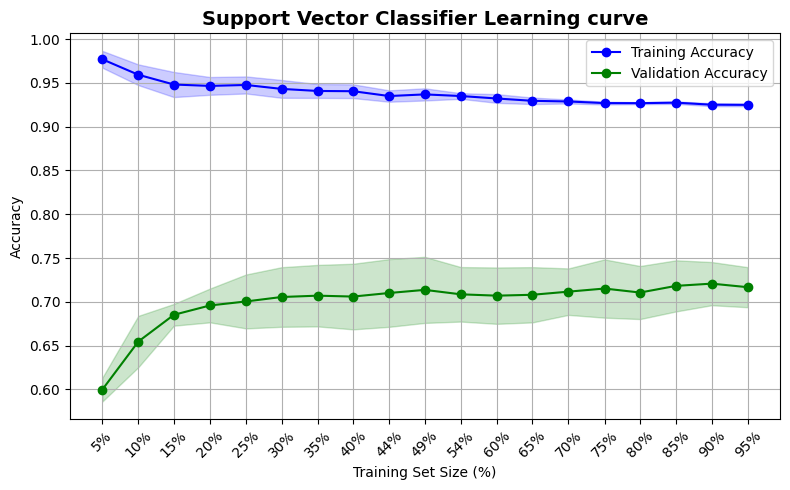

In [45]:
joblib.dump(best_model["clf"], best_model['name'])
plot_learning_curve(best_model["clf"], X, y, f"{best_model['name']} Learning curve")

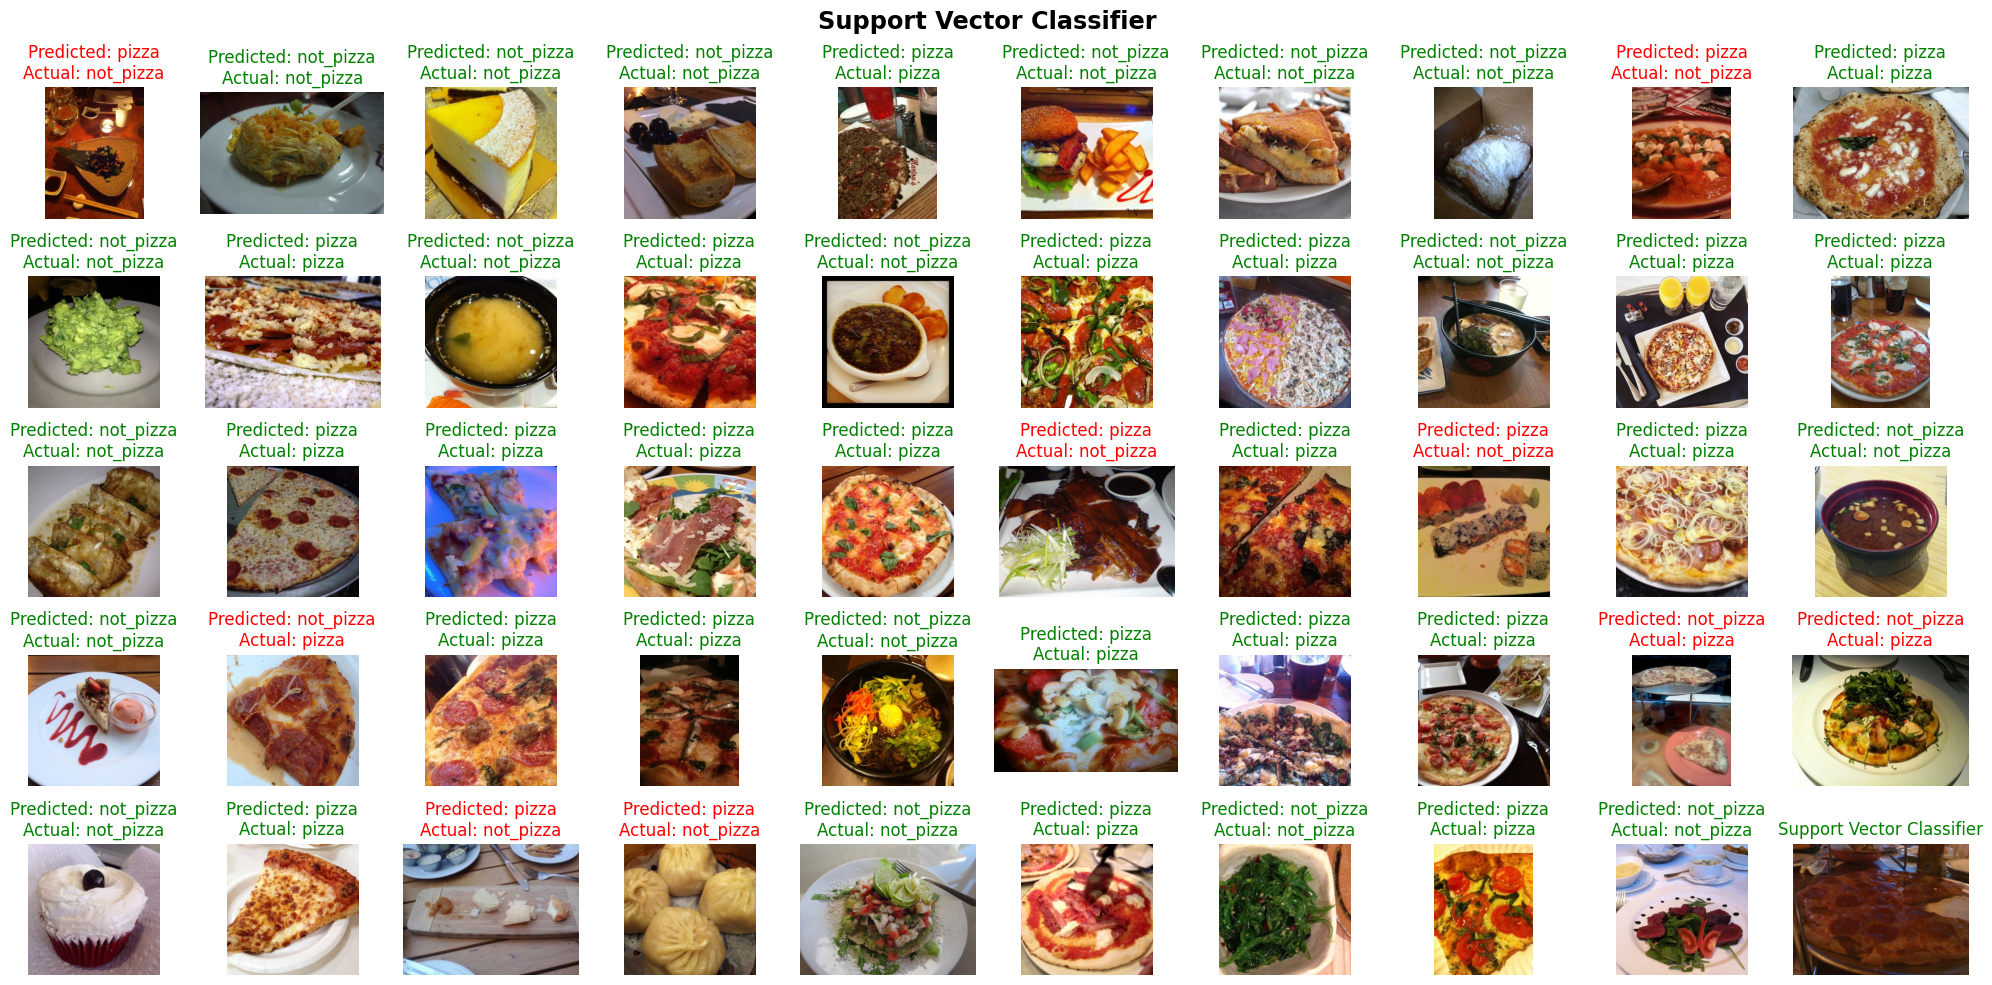

In [95]:
num_images_to_show = 50
rows = num_images_to_show // 10
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(num_images_to_show):
    rand_idx = np.random.randint(len(image_paths))
    image = imread(image_paths[rand_idx])

    x = scaler.transform(extract_features_from_image(image_paths[rand_idx], FEATURES))
    x = pca.transform(x)
    pred = best_model["clf"].predict(x)[0]
    true = labels[rand_idx]
    color = 'green' if pred == true else 'red'

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {pred}\nActual: {true}", fontsize=12, color=color)
fig.suptitle(f"{best_model['name']}", weight="bold", size="xx-large")
plt.title(f"{best_model['name']}")
plt.tight_layout()
plt.show()

In [47]:
# Step 1: Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 10, 20],
        'weights': ['uniform', 'distance']
    },
    "Support Vector Classifier": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Naive Bayes": {
        # No hyperparameters to tune for basic GaussianNB
    }
}


In [96]:
best_model_name = best_model["name"]
print(f"Running GridSearchCV for: {best_model_name}")

best_model_optimized = {
    "score": 0,
    "clf": None,
    "name": ""
}

# Only run GridSearchCV if the model has a parameter grid
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    base_model = clone(models[best_model_name])

    # Run grid search using the defined function
    optimized_clf = train_grid_search(base_model, param_grid, X_train_pca, X_test_pca, encoded_y_train, encoded_y_test)

    # Save optimized model
    best_model_optimized["clf"] = optimized_clf
    best_model_optimized["name"] = best_model_name + " Optimized"
    print(f"GridSearchCV completed for: {best_model_name}")

else:
    print(f"No hyperparameters to tune for model: {best_model_name}")


Running GridSearchCV for: Support Vector Classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.540 total time=   1.5s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.564 total time=   1.3s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.515 total time=   1.1s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.571 total time=   1.2s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.596 total time=   1.2s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.723 total time=   0.9s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.683 total time=   1.0s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.748 total time=   0.9s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.671 total time=   0.9s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.703 total time=   1.1s
[CV 1/5] END ................C=1, kernel=linear;, score=0.540 total time=   1.

In [97]:
clf = clone(best_model_optimized["clf"])
clf.fit(X_train_pca, y_train)

y_pred_train = clf.predict(X_train_pca)
y_pred_test = clf.predict(X_test_pca)

print(f"\n--- {best_model_optimized['name']} ---")
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X_train_pca, encoded_y_train, cv=5, scoring='f1')
mean_score = scores.mean()
print("CV train scores:", scores, "→ mean:", mean_score)

if mean_score > best_model_optimized["score"]:
    best_model_optimized["score"] = mean_score

print("\n" + "=" * 60)
print(">> Best model Optimized:")
print(f"{best_model_optimized['name']} with mean CV f1-score: {best_model_optimized['score']:.4f}")


--- Support Vector Classifier Optimized ---
Train Metrics
              precision    recall  f1-score   support

   not_pizza       0.92      0.94      0.93       786
       pizza       0.94      0.91      0.93       786

    accuracy                           0.93      1572
   macro avg       0.93      0.93      0.93      1572
weighted avg       0.93      0.93      0.93      1572

Test Metrics
              precision    recall  f1-score   support

   not_pizza       0.86      0.49      0.62       197
       pizza       0.64      0.92      0.76       197

    accuracy                           0.71       394
   macro avg       0.75      0.71      0.69       394
weighted avg       0.75      0.71      0.69       394

CV train scores: [0.79617834 0.72025723 0.69902913 0.73076923 0.67507886] → mean: 0.7242625600023735

>> Best model Optimized:
Support Vector Classifier Optimized with mean CV f1-score: 0.7243


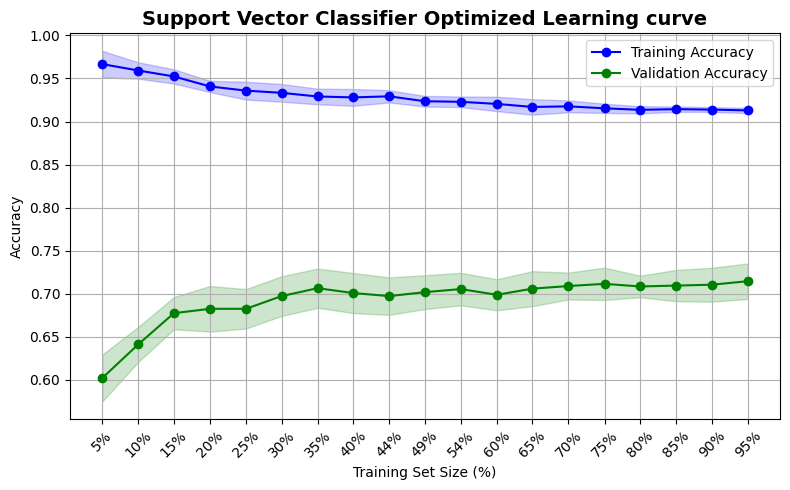

In [87]:
joblib.dump(best_model_optimized["clf"], best_model_optimized['name'])
plot_learning_curve(best_model_optimized["clf"], X, y, f"{best_model_optimized['name']} Learning curve")

In [104]:
pred

np.int64(1)

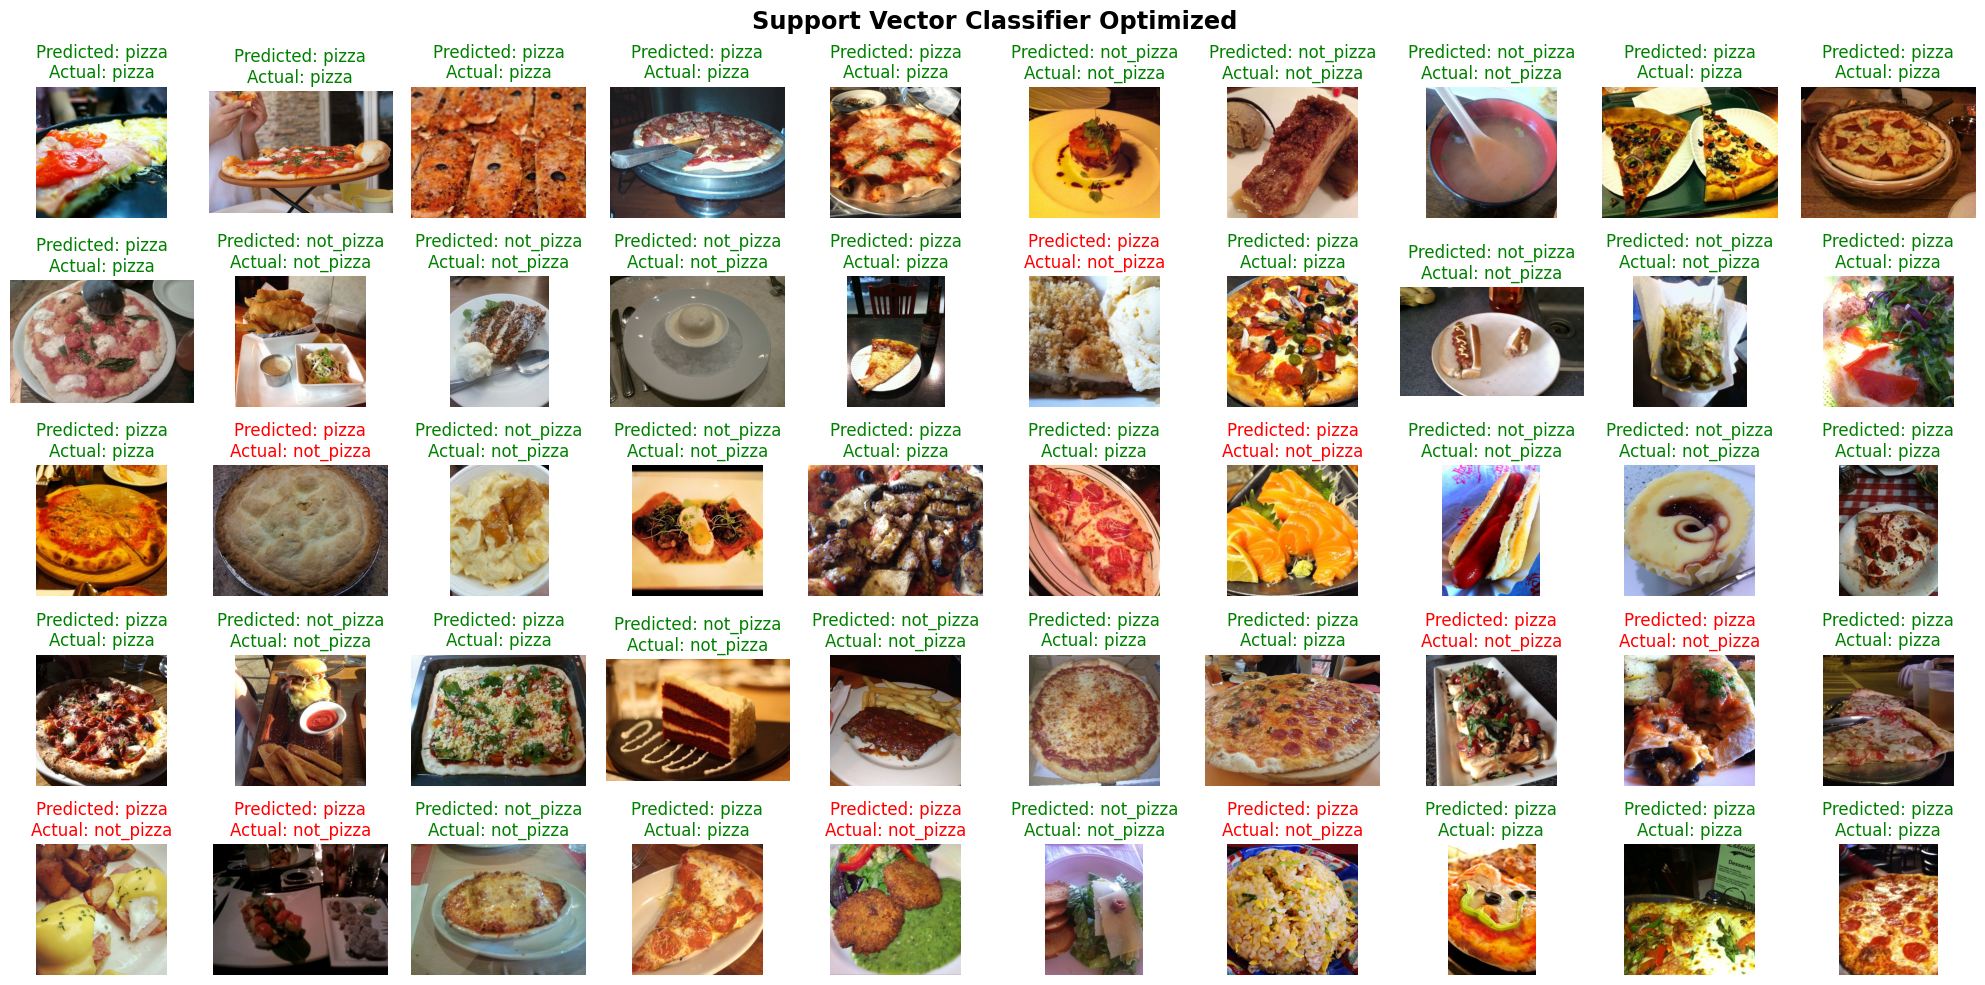

In [108]:
num_images_to_show = 50
rows = num_images_to_show // 10
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(num_images_to_show):
    rand_idx = np.random.randint(len(image_paths))
    image = imread(image_paths[rand_idx])

    x = scaler.transform(extract_features_from_image(image_paths[rand_idx], FEATURES))
    x = pca.transform(x)
    pred = encoder.inverse_transform([best_model_optimized["clf"].predict(x)[0]])[0]
    true = labels[rand_idx]
    color = 'green' if pred == true else 'red'

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {pred}\nActual: {true}", fontsize=12, color=color)
fig.suptitle(f"{best_model_optimized['name']}", weight="bold", size="xx-large")
plt.tight_layout()
plt.show()